### 다양한 분석을 위해 금융 도메인 특성에 맞게 데이터를 재해석하고 시각화

1. 거래 유형(CASH_IN, CASH_OUT, TRANSFER 등) 분포 분석
2. 정상 거래 vs 사기 거래 패턴 비교
3. 거래 금액, 빈도, 시간(step) 기반 이상 패턴 탐색

*사기로 탐지된 거래는 취소됩니다. 따라서 사기 탐지를 위해 잔액 관련 열(oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest)을 사용해서는 안 됩니다. *

->사기 거래가 발생하면 시스템이 이를 차단하고 거래를 취소하기 때문에, 결과적으로 계좌 잔액에 변화가 생기지 않게됨,
사기거래 분석에선 해당 열 사용 X

---

**SQL → pandas DataFrame → 시각화 방법**

(1) 먼저 DB 연결을 파이썬 쪽에서 잡아놓기

(2) read_sql로 쿼리 결과를 DataFrame으로 가져오기

(3) 바로 시각화 (matplotlib or seaborn)

---

거래 유형(type)별 평균 금액 비교 (Bar Chart)

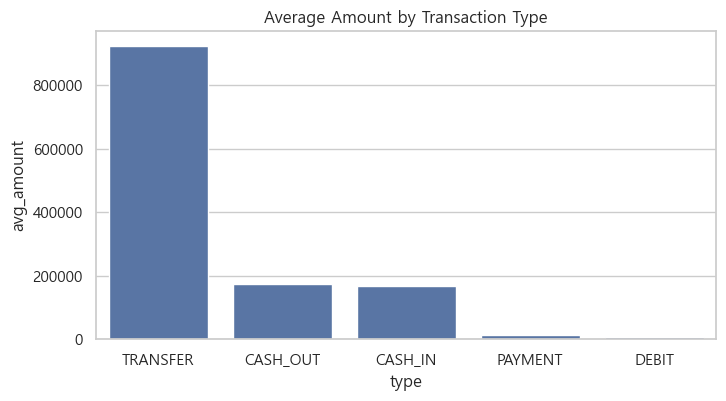

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

query = """
SELECT type, AVG(amount) AS avg_amount
FROM PaySim
GROUP BY type
ORDER BY avg_amount DESC;
"""

engine = create_engine("sqlite:///paysim.db")
df = pd.read_sql(query, engine)

plt.figure(figsize=(8, 4))
sns.barplot(df, x="type", y="avg_amount")
plt.title("Average Amount by Transaction Type")
plt.show()


Fraud 비율 시각화

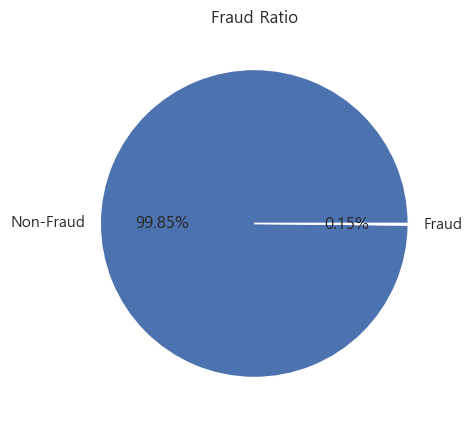

In [12]:
query = """
SELECT isFraud, COUNT(*) AS cnt
FROM PaySim
GROUP BY isFraud;
"""

df = pd.read_sql(query, engine)

plt.figure(figsize=(5, 5))
plt.pie(df["cnt"], labels=["Non-Fraud", "Fraud"], autopct="%.2f%%")
plt.title("Fraud Ratio")
plt.show()


정상 거래 vs 사기 거래 기본 패턴 비교

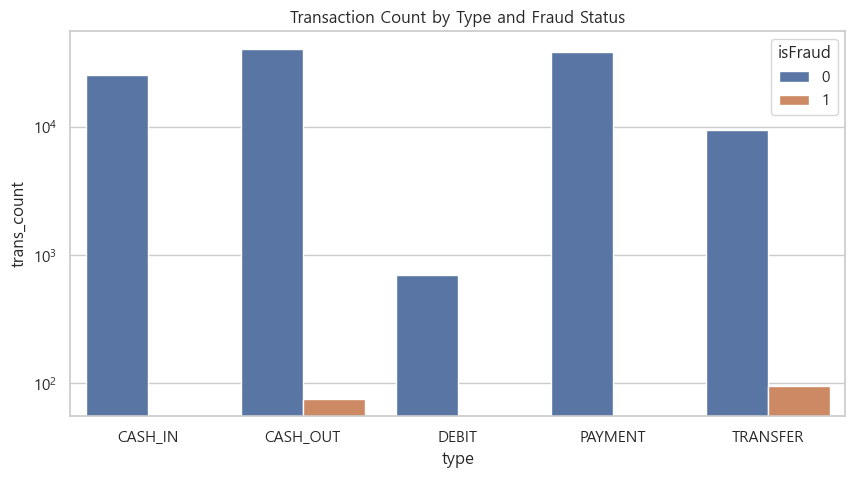

In [ ]:
query1 = """
SELECT 
    type, 
    isFraud, 
    COUNT(*) AS trans_count, 
    AVG(amount) AS avg_amount
FROM PaySim
GROUP BY type, isFraud
ORDER BY type, isFraud;
"""

df_stats = pd.read_sql(query1, engine)

# 시각화: 거래 유형별 사기 발생 횟수 비교
plt.figure(figsize=(10, 5))
sns.barplot(data=df_stats, x="type", y="trans_count", hue="isFraud")
plt.title("Transaction Count by Type and Fraud Status")
plt.yscale('log') # 데이터 편차가 크므로 로그 스케일 적용
plt.show()

거래 금액 및 시간(step) 기반 이상 패턴 탐색

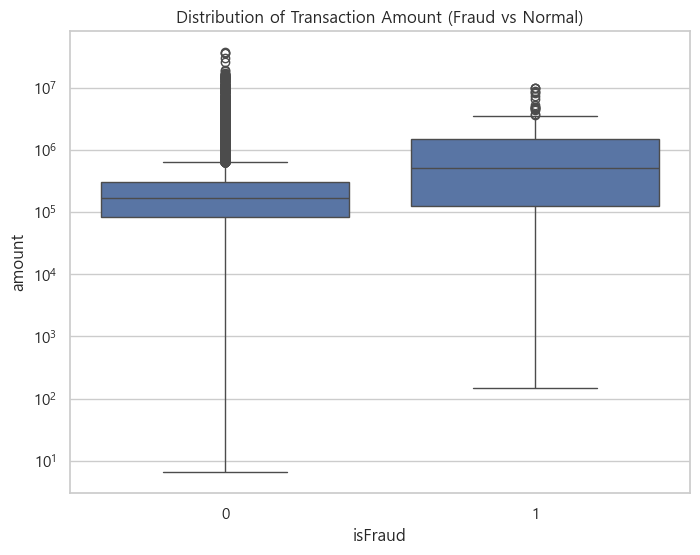

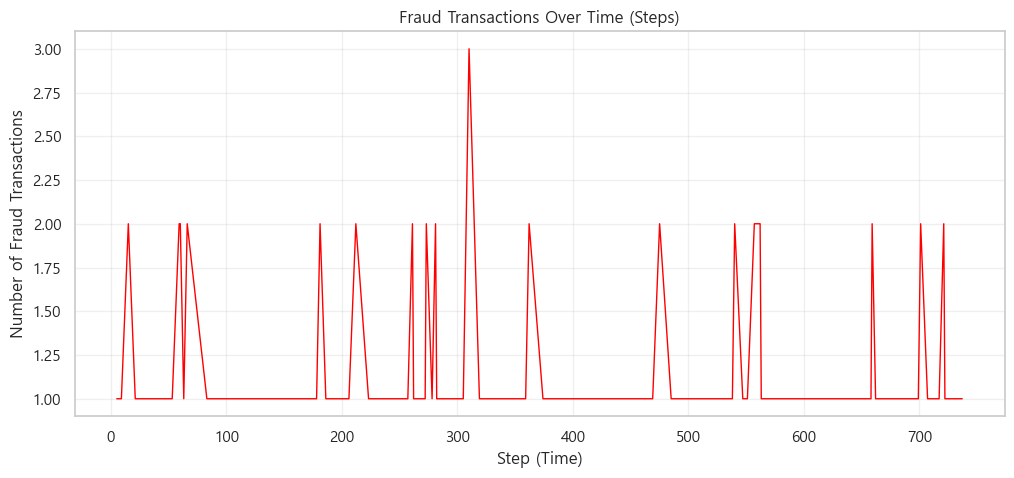

In [8]:
# 2. 금액 분포 및 시간 흐름 분석을 위한 샘플 데이터 추출
# 데이터가 너무 크면 전체를 가져오기보다 사기 전체 + 정상 일부를 샘플링하는 것이 좋습니다.
query2 = """
SELECT step, type, amount, isFraud
FROM PaySim
WHERE type IN ('TRANSFER', 'CASH_OUT');
"""

df_pattern = pd.read_sql(query2, engine)

# (1) 거래 금액 분포 비교 (Boxplot)
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_pattern, x="isFraud", y="amount")
plt.title("Distribution of Transaction Amount (Fraud vs Normal)")
plt.yscale('log') # 금액 차이가 크므로 로그 스케일 권장
plt.show()

# (2) 시간(step)에 따른 사기 발생 빈도 탐색
# step당 사기 거래 건수 집계
fraud_time = df_pattern[df_pattern['isFraud'] == 1].groupby('step').size().reset_index(name='fraud_count')

plt.figure(figsize=(12, 5))
plt.plot(fraud_time['step'], fraud_time['fraud_count'], color='red', linewidth=1)
plt.title("Fraud Transactions Over Time (Steps)")
plt.xlabel("Step (Time)")
plt.ylabel("Number of Fraud Transactions")
plt.grid(True, alpha=0.3)
plt.show()

RFM 분석을 위한 준비: 고객별 거래 활동량 조사

- 고객별로 얼마나 자주, 얼마나 큰 금액을 거래하는지 파악하여 헤비 유저와 사기 의심군을 분류함

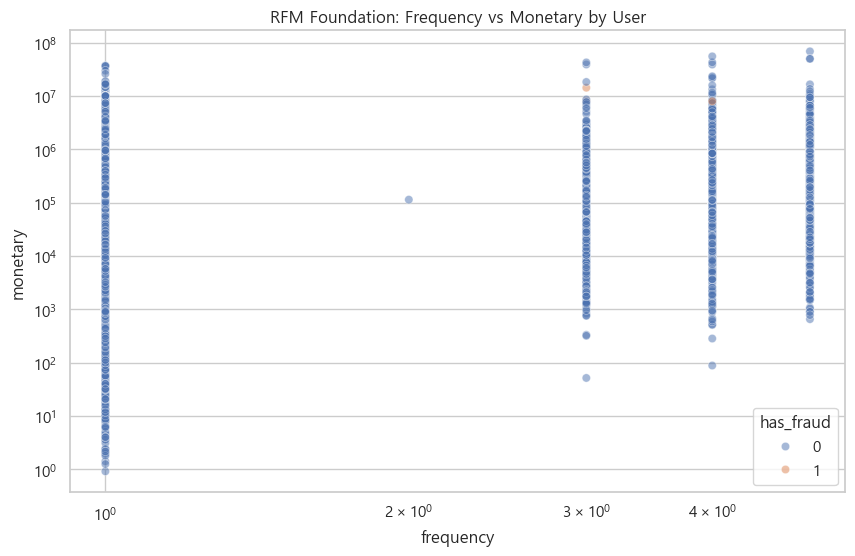

In [14]:
# SQL: 고객별 거래 횟수(F)와 총 금액(M) 집계
query_rfm = """
SELECT 
    nameOrig, 
    COUNT(step) AS frequency, 
    SUM(amount) AS monetary,
    MAX(isFraud) AS has_fraud -- 해당 고객이 사기를 친 적이 있는지 표시
FROM PaySim
GROUP BY nameOrig;
"""
df_rfm = pd.read_sql(query_rfm, engine)

# 시각화: 거래 빈도와 총 금액의 관계 (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_rfm, x="frequency", y="monetary", hue="has_fraud", alpha=0.5)
plt.yscale('log')
plt.xscale('log')
plt.title("RFM Foundation: Frequency vs Monetary by User")
plt.show()

AARRR & 퍼널 분석용: 송금 후 인출 전환율 (Path Conversion)

- PaySim에서 퍼널(Funnel)은 보통 자금의 흐름으로 정의
- 사기 거래의 전형적인 경로인 TRANSFER -> CASH_OUT 전환 구조를 분석

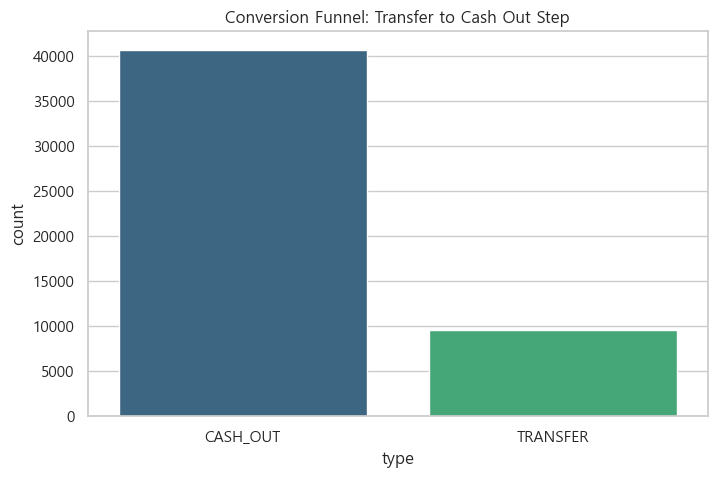

In [18]:
# SQL: 송금과 인출의 전체 건수 비교
query_funnel = """
SELECT type, COUNT(*) AS count
FROM PaySim
WHERE type IN ('TRANSFER', 'CASH_OUT')
GROUP BY type;
"""
df_funnel = pd.read_sql(query_funnel, engine)

# 시각화: 단순 퍼널 구조 (Bar Chart)
plt.figure(figsize=(8, 5))
sns.barplot(data=df_funnel, x="type", y="count", hue="type", palette="viridis")
plt.title("Conversion Funnel: Transfer to Cash Out Step")
plt.show()

유동성 및 경로 분석: 수신자 집중도 (Destination Centrality)

- 특정 계좌(nameDest)로 자금이 얼마나 몰리는지 확인하여 '자금 세탁' 거점을 찾음

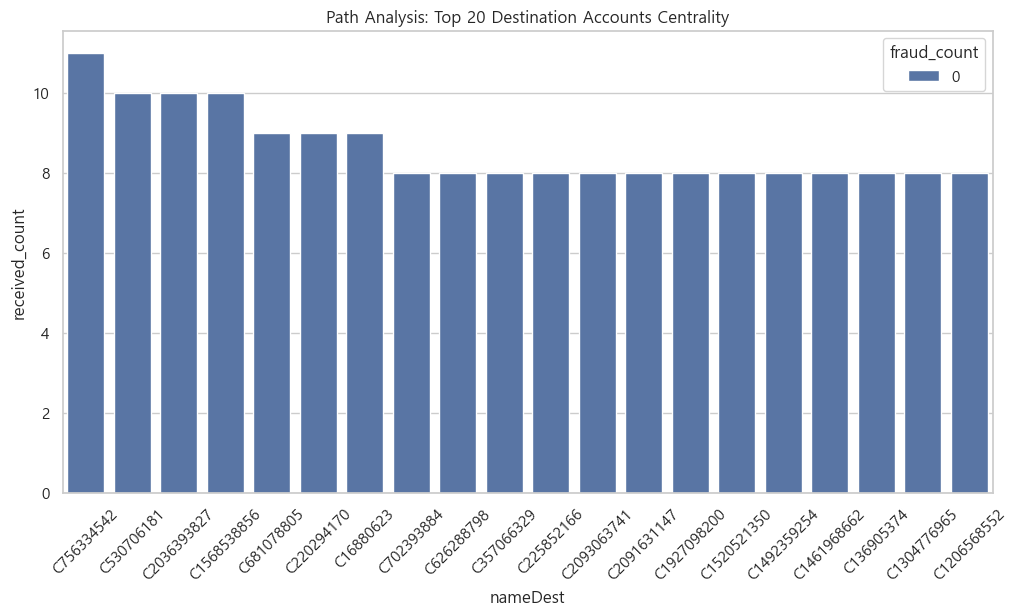

In [17]:
# SQL: 수신 계좌별 입금 횟수 및 사기 연루 건수
query_dest = """
SELECT 
    nameDest, 
    COUNT(*) AS received_count, 
    SUM(isFraud) AS fraud_count
FROM PaySim
GROUP BY nameDest
HAVING received_count > 5
ORDER BY received_count DESC
LIMIT 20;
"""
df_dest = pd.read_sql(query_dest, engine)

# 시각화: 수신 집중도 상위 계좌와 사기 연관성
plt.figure(figsize=(12, 6))
sns.barplot(data=df_dest, x="nameDest", y="received_count", hue="fraud_count")
plt.xticks(rotation=45)
plt.title("Path Analysis: Top 20 Destination Accounts Centrality")
plt.show()

세그멘테이션: 거래 금액 규모별 프로파일링

-  거래 금액의 크기에 따라 유저를 그룹화(Binning)하고 사기율을 비교

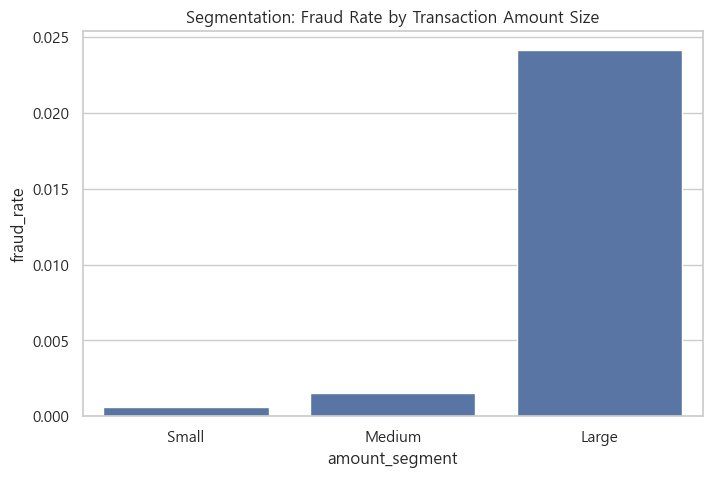

In [20]:
# SQL: 금액 구간별 사기율 계산
query_seg = """
SELECT 
    CASE 
        WHEN amount <= 100000 THEN 'Small'
        WHEN amount <= 1000000 THEN 'Medium'
        ELSE 'Large'
    END AS amount_segment,
    AVG(isFraud) AS fraud_rate,
    COUNT(*) AS total_count
FROM PaySim
GROUP BY amount_segment;
"""
df_seg = pd.read_sql(query_seg, engine)

# 시각화: 세그먼트별 사기율 (Percentage Bar)
plt.figure(figsize=(8, 5))
sns.barplot(data=df_seg, x="amount_segment", y="fraud_rate", order=['Small', 'Medium', 'Large'])
plt.title("Segmentation: Fraud Rate by Transaction Amount Size")
plt.show()

사기 탐지 최적화: 시간 밀집도 (Time Density)

- step을 24시간 주기로 변환하여 사기가 발생하는 '위험 시간대'를 식별

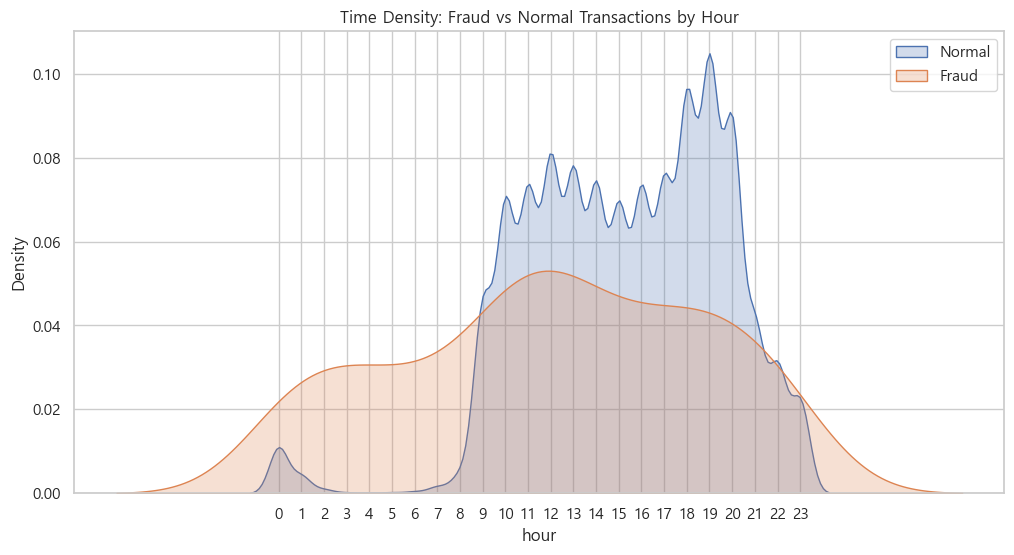

In [21]:
# 파이썬에서 step을 시간으로 변환 (1 step = 1 hour 가정)
query_time = "SELECT step, isFraud FROM PaySim"
df_time = pd.read_sql(query_time, engine)

df_time['hour'] = df_time['step'] % 24

# 시각화: 시간대별 사기 발생 밀도 (KDE Plot)
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_time[df_time['isFraud'] == 0], x="hour", label="Normal", fill=True)
sns.kdeplot(data=df_time[df_time['isFraud'] == 1], x="hour", label="Fraud", fill=True)
plt.title("Time Density: Fraud vs Normal Transactions by Hour")
plt.xticks(range(0, 24))
plt.legend()
plt.show()